In [1]:
import os
import numpy as np
import cv2
import datetime
import json
import tensorflow as tf
from PIL import Image
from utils import preview
from imgaug import augmenters as iaa
from math import ceil
import IPython.display as display

loaded=False  # Used as a flag to avoid reloading image data multiple times

# Function definition

### Load object images

In [2]:
def load_images(image_dir):
    """
    Load transparent object images from a directory
    """
    # Image file paths
    image_files = os.listdir(image_dir)
    image_files.remove('.DS_Store')
    image_files = [os.path.join(image_dir, f) for f in image_files] 

    # Load images
    images = []
    for f in image_files:
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
        images.append(img)

    return images

### Augment object images

In [3]:
def pad_image(img, padding=10):
    """
    Pad the outer edges of a 2D image with a constant value
    
    Arguments:
    - img - numpy array - image to pad
    - padding - int - padding to apply
    - constant - int - constant value to pad with
    
    Returns:
    - image_padded - numpy array - padded image
    """
    img = img.copy()
    img_padded = np.zeros(
        shape=(img.shape[0] + padding*2, img.shape[1] + padding*2, img.shape[2]),
        dtype=img.dtype
    )
    img_padded[padding:-padding, padding:-padding] = img
    return img_padded

In [4]:
def binarise_alpha(image, crop=False):
    """
    Restores the alpha channel to 0 or 255 after image augmentation distorts it
    
    Arguments:
    - image - numpy array - image to restore the alpha channel for
    - crop - bool - whether to crop the image using the alpha channel
    
    Returns:
    - image - numpy array - image with transparent background
    """
    image = image.copy()
    
    # Binarise the alpha channel
    alpha_channel = image[:, :, 3]
    alpha_channel = (alpha_channel >= 128) * 255
    image[:, :, 3] = alpha_channel
    # Set all channels to 0 if alpha is 0 for that pixel
    alpha_zero = (alpha_channel == 0)
    image[alpha_zero] = 0

    # Crop away any parts of the image that have 0 alpha
    if crop:
        object_pixels = np.where(~alpha_zero)
        xmin, xmax = object_pixels[0].min(), object_pixels[0].max()
        ymin, ymax = object_pixels[1].min(), object_pixels[1].max()
        image = image[xmin:xmax, ymin:ymax]
        
    return image

In [5]:
def augment_images(images):
    """
    Augment transparent object images using imgaug
    """
    seq = iaa.Sequential(
        [
            # Horizontal flips
            iaa.Fliplr(0.5),
            # Small gaussian blur 
            iaa.Sometimes(
                0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.LinearContrast((0.75, 1.5)),
            # Add gaussian noise
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Scale/zoom and rotate
            iaa.Affine(
                scale={"x": (0.6, 1), "y": (0.6, 1)},
                rotate=(-10, 10)
            )
        ],
        random_order=True
    )
    
    # Pad images, augment, binarize alpha channel and crop away transparent edges
    images = [pad_image(img, padding=50) for img in images]
    images_aug = seq(images=images)
    images_aug = [binarise_alpha(img, crop=True) for img in images_aug]
    
    return images_aug

### Load texture images

In [6]:
def load_textures(texture_dir):
    """
    Load texture images from the subdirectories of texture_dir
    """
    # Texture image file paths
    texture_folders = os.listdir(texture_dir)
    texture_folders.remove('.DS_Store')

    # Recursively get texture image file paths
    texture_files = []
    for folder in texture_folders:
        folder_files = os.listdir(os.path.join(texture_dir, folder))
        for file in folder_files:
            if file != '.directory':
                texture_files.append(os.path.join(texture_dir, folder, file))

    # Load texture images
    textures = []
    for f in texture_files:    
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        textures.append(img)

    return textures

### Generate training images from object and texture images

In [15]:
def add_background(bg, obj, x, y, image_size):
    """
    Add an object to a background at position x, y
    The background will be resized to be square and a multiple of 32
    x, y and the object size will be adjusted to fit the object on the background
    
    Arguments:
    - obj - numpy array - object image to overlay on the background
    - bg - numpy array - background image
    - x - int - x coordinate for the top left of the image
    - y - int - y coordinate for the top left of the image
    - image_size - int - height and width of the output image (in pixels)
    
    Returns:
    - img - numpy array - object image pasted onto the background image 
    - bbox - dict - bounding box for the object
    """
    # Resize background to be of specified length
    bg = bg.copy()
    bg_height, bg_width = bg.shape[0], bg.shape[1]
    if (bg_height < image_size) or (bg_width < image_size):
        num_tiles = ceil(max(image_size/bg_height, image_size/bg_width))
        bg = np.tile(bg, (num_tiles, num_tiles, 1))
    bg = bg[:image_size, :image_size]
    
    # Default output (no object)
    img = Image.fromarray(bg)
    bbox = {'x': -1, 'y': -1, 'height': -1, 'width': -1}

    # Paste object onto the background
    if obj is not None:
        obj = obj.copy()
        # Resize the object so that it fits on the image
        obj_height, obj_width = obj.shape[0], obj.shape[1]
        while (obj_height >= image_size * 0.5) or (obj_width >= image_size * 0.5):
            obj = obj[::2, ::2]
            obj_height, obj_width = obj.shape[0], obj.shape[1]
        # Paste the object onto the background
        x = x % (image_size - obj_width)
        y = y % (image_size - obj_height)
        obj = Image.fromarray(obj)
        img.paste(obj, (x, y), obj)
        # Bounding box for object detection - x and y represent the center point
        bbox = {
            'x': int(x + (obj_width/2)),
            'y': int(y + (obj_height/2)),
            'width': obj_width,
            'height': obj_height
        }
        
    # Remove alpha channel
    img = np.array(img)[:, :, :3]
    return img, bbox

In [16]:
def generate_images(backgrounds, objects=None, num_samples=1, image_size=224):
    """
    Generate images from background and object images
    If no object image is provided, the background image will simply be resized
    
    Arguments:
    - backgrounds: list of background images
    - objects: list of object images with transparent backgrounds
    - num_samples: number of images to generate
    """
    # Generate training images
    for i in range(num_samples):
        print(f'Progress: {i+1}/{num_samples}', end='\r')
        # Random sample (don't use np.random.choice, in case all images have same dimensions)
        bg = backgrounds[np.random.randint(0, len(backgrounds)-1)]
        if objects is not None:
            obj = objects[np.random.randint(0, len(objects)-1)]
            x = np.random.randint(0, bg.shape[1])
            y = np.random.randint(0, bg.shape[0])
        else:
            obj = x = y = None
        # Generate image - returns resized background image if obj is None
        training_image, bbox = add_background(bg, obj, x, y, image_size)
        yield training_image, bbox

### Save generated images as .tfrecords

In [17]:
def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_to_tfexample(image_raw, label, bbox):
    """Create a tf.Example object from an image"""
    feature = {
        'image_raw': bytes_feature(image_raw),
        'label': bytes_feature(label),
        'bbox': bytes_feature(bbox)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [18]:
def generate_and_save_images(backgrounds, objects, num_samples, data_split, output_dir,
                             image_size=224):
    """
    Generate and save images as .tfrecords
        
    Arguments:
    - backgrounds: list of background images
    - objects: list of object images with transparent backgrounds
    - num_samples: total number of images to generate
    - data_split: how to split num_samples across train/val/test splits
    - output_dir: where to save the tfrecords
    - image_size: image_size passed to `generate_images`
    """
    assert sum(data_split) == 100, ValueError("Data split should sum to 100")
    
    # Calculate number of samples per dataset and save metadata in JSON file
    sample_sizes = {
        'train': int(num_samples * data_split[0]/100),
        'val': int(num_samples * data_split[1]/100),
        'test': int(num_samples * data_split[2]/100)
    }
    metadata = {
        'num_examples': sample_sizes,
        'dimensions': {'height': image_size, 'width': image_size, 'channels': 3}
    }
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    json.dump(metadata, open(os.path.join(output_dir, 'METADATA.json'), 'w'))
    
    # Create a .tfrecord file per dataset
    for dataset in ['train', 'val', 'test']:
        print(f'\nGenerating {dataset} data...')
        samples_per_label = int(sample_sizes[dataset] / 2)

        record_file = os.path.join(output_dir, f'{dataset}.tfrecord')
        with tf.io.TFRecordWriter(record_file) as writer:
            
            # Generate and save positive examples (object pasted onto a background)
            print(f'Generating {samples_per_label} positive training examples')
            positive_images = generate_images(backgrounds, objects, samples_per_label, image_size)
            for image, bbox in positive_images:
                tf_example = image_to_tfexample(
                    image_raw=image.tobytes(),
                    label=b'stickie',
                    bbox=json.dumps(bbox).encode()
                )
                writer.write(tf_example.SerializeToString())
            
            # Generate and save negative examples (these just contain a background)
            print(f'Generating {samples_per_label} negative training examples')
            negative_images = generate_images(backgrounds, None, samples_per_label, image_size)
            for image, bbox in negative_images:
                tf_example = image_to_tfexample(
                    image_raw=image.tobytes(),
                    label=b'texture',
                    bbox=json.dumps(bbox).encode()
                )
                writer.write(tf_example.SerializeToString())
    
        print(f"Saved images to: '{record_file}'")

# Run pipeline

In [19]:
if not loaded:
    
    # Load images
    print('Loading object images...')
    images = load_images('../data/interim/images/')
    # Preview
    for image in images[:2]:
        preview(image, size=50)

    # Augment images (twice, then append the original images)
    print('Augmenting object images...')
    images_aug = augment_images(images)
    images_aug.extend(augment_images(images))
    images_aug.extend(images)
    # Preview
    for image in images_aug[:2]:
        preview(image, size=50)

    # Load textures
    print('Loading texture images...')
    textures = load_textures('../data/raw/dtd/images/')
    #textures = [np.array((np.random.random((224,224,3)) * 255), dtype='uint8') for _ in range(100)]
    # Preview
    for texture in textures[:2]:
        preview(texture, size=50)
    
    loaded = True

In [20]:
# Generate images
sample_size = 10000
data_split = (80, 10, 10)
time = datetime.datetime.now().strftime('%y%m%d_%H%M%S')
output_dir = '../data/processed/tfrecords/' + time
print('Generating images...')
generate_and_save_images(textures, images_aug, sample_size, data_split, output_dir)

Generating images...

Generating train data...
Generating 4000 positive training examples
Generating 4000 negative training examples
Saved images to: '../data/processed/tfrecords/200429_183441/train.tfrecord'

Generating val data...
Generating 500 positive training examples
Generating 500 negative training examples
Saved images to: '../data/processed/tfrecords/200429_183441/val.tfrecord'

Generating test data...
Generating 500 positive training examples
Generating 500 negative training examples
Saved images to: '../data/processed/tfrecords/200429_183441/test.tfrecord'


# View result and upload to cloud

## Read saved record

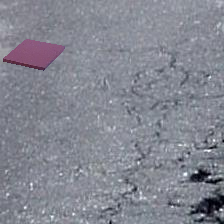

In [21]:
# Read
raw_image_dataset = tf.data.TFRecordDataset(os.path.join(output_dir, 'train.tfrecord'))

image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.string),
    'bbox': tf.io.FixedLenFeature([], tf.string)
}
def parse_image_function(tf_example):
    # Parse an input tf.Example proto using the 
    return tf.io.parse_single_example(tf_example, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(parse_image_function)
for example in parsed_image_dataset.take(1):
    display.display(Image.frombytes('RGB', (224, 224), example['image_raw'].numpy()))

### Save records to Cloud Storage

In [22]:
from google.cloud import storage

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../credentials/sticky-notes1-data-access.json'
storage.blob._DEFAULT_CHUNKSIZE = 5 * 1024 * 1024 # 5 MB

client = storage.Client()
bucket = client.get_bucket('sticky-notes1')

for file_name in os.listdir(output_dir):
    if file_name != '.DS_Store':
        blob = bucket.blob(f'training-data/{file_name}')
        file_path = os.path.join(output_dir, file_name)
        blob.upload_from_filename(file_path)